In [2]:
!pip install scanpy matplotlib numpy pandas pybiomart leidenalg scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [2]:

# !pip install --no-cache-dir --force-reinstall h5py scanpy

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
# from pybiomart import Server
import scipy.sparse

# Step 1: Load Dataset

In [3]:
# Load expression data for all three datasets
# Transpose to match Scanpy format
arg = sc.read("/kaggle/input/rnaaseq/Arg_batch1.csv").T
pb_batch1 = sc.read("/kaggle/input/rnaaseq/PJ_batch1.csv").T
pb_batch2 = sc.read("/kaggle/input/rnaaseq/PJ_batch2.csv").T
# Load metadata
# Drop the first column of the metadata which contains the index
arg_meta = pd.read_csv("/kaggle/input/rnaaseq/Arg_batch1_meta.csv").iloc[:, 1:]
pb_meta_batch1 = pd.read_csv("/kaggle/input/rnaaseq/PJ_batch1_meta.csv").iloc[:, 1:]
pb_meta_batch2 = pd.read_csv("/kaggle/input/rnaaseq/PJ_batch2_meta.csv").iloc[:, 1:]

In [4]:
# Set cell names as index
arg_meta.set_index("cell", inplace=True)
pb_meta_batch1.set_index("cell", inplace=True)
pb_meta_batch2.set_index("cell", inplace=True)


# Ensure metadata order matches expression data
arg.obs = arg_meta.loc[arg.obs_names]
pb_batch1.obs = pb_meta_batch1.loc[pb_batch1.obs_names]
pb_batch2.obs = pb_meta_batch2.loc[pb_batch2.obs_names]

# Step 2: Quality Control
We have 3 datasets here, two batches of Pijuan dataset and one dataset from Argelaguet. In this section the goal is to assess what quality control measures have been performed on all the datasets and to note any differences between the thresholds used for these quality control methods.
The quality control methods and their explanations are as follows:

1.  Coverage Threshold


*   What it does: Removes cells that have low total UMI counts across all genes.
*   Why: Low total counts suggest insufficient sequencing coverage, leading to unreliable gene expression estimates. Ensures that only cells with sufficient RNA content are retained.
*  How: Cells with total UMI counts below a set threshold are removed.

2.   Gene Expression


*   What it does: Removes cells that express very few genes.
*   Why: Cells with low gene complexity may be empty droplets or low-quality cells with insufficient RNA content. Retaining these cells can introduce noise and affect clustering analysis.
*   How: Cells with fewer than a threshold number of expressed genes are removed.

3.   Mitochondrial Gene Expression


*   What it does: Excludes cells with excessive mitochondrial RNA content.
*   Why: High mitochondrial gene expression is often a sign of damaged or stressed cells. These cells may bias downstream analyses.
*   How: Cells where mitochondrial RNA makes up more than a threshold %  of total counts are removed.


4. Top 50 Gene Expression



*   What it does: Removes cells where gene expression is highly dominated by just a few genes.
*   Why: If the top 50 genes contribute heavily to total reads, the cell likely has low transcript diversity and may be non-biological or an outlier. Helps retain cells with diverse and representative expression profiles.
*  How: Compute the fraction of total UMI counts contributed by the top 50 most expressed genes per cell. Remove cells where this fraction exceeds the set threshold.




5. Doublet Removal

* What it does: Detects and removes potential doublet cells.
* Why: Doublets (two or more cells captured in the same droplet) can skew results by artificially inflating expression values and distorting clustering. Removing doublets helps ensure that each cell represents a single biological unit.
* How:
Compute doublet scores using local cell density in PCA space.
Cluster cells using the Leiden algorithm.
Apply a MAD-based threshold with Benjamini-Hochberg correction to identify and remove high-score doublets.
Cells in clusters with median doublet scores above the threshold are labeled as doublets and removed.











In [5]:
# Calculate QC metrics (this creates 'n_genes_by_counts' and 'total_counts' columns)
sc.pp.calculate_qc_metrics(arg, percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(pb_batch1, percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(pb_batch2, percent_top=None, log1p=False, inplace=True)


# Now check available columns in metadata
print(arg.obs.columns)
print(pb_batch1.obs.columns)
print(pb_batch2.obs.columns)

#Metadata now has two additional columns 'n_genes_by_counts' & 'total_counts'
#'n_genes_by_counts' holds the number of genes expressed per cell
#'total_counts' holds the total UMI count for all genes in a cell

Index(['pass_rnaQC', 'stage', 'celltype', 'n_genes_by_counts', 'total_counts'], dtype='object')
Index(['stage', 'celltype', 'n_genes_by_counts', 'total_counts'], dtype='object')
Index(['stage', 'celltype', 'n_genes_by_counts', 'total_counts'], dtype='object')


In [11]:
arg.obs["pass_rnaQC"].unique()

array([ True, False])

It is important to note here that metadata for Argelaguet Dataset has an additional column 'pass_rnaQC'.

To understand the significance of this field, one has to look at the statistics for all the datasets


In [6]:
#separate dataframe for cells in Argelaguet dataset where pass_rnaQC is True
arg_pass_rnaQC = arg[arg.obs["pass_rnaQC"] == True, :]

#calculating QC metrics for this dataset
sc.pp.calculate_qc_metrics(arg_pass_rnaQC, percent_top=None, log1p=False, inplace=True)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_qc.py:144: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [13]:
# Compute statistics for each dataset, including the number of cells
def compute_stats(adata):
    total_counts = adata.obs["total_counts"]
    n_genes = adata.obs['n_genes_by_counts']
    return {
        "Number of Cells": adata.n_obs,
        
        "Total Counts (Min)": total_counts.min(),
        "Total Counts (Max)": total_counts.max(),
        "Total Counts (Mean)": total_counts.mean(),
        "Total Counts (Median)": np.median(total_counts),
        "Total Counts (Std Dev)": total_counts.std(),
        
        "Number of Genes (Min)": n_genes.min(),
        "Number of Genes (Max)": n_genes.max(),
        "Number of Genes (Mean)": n_genes.mean(),
        "Number of Genes (Median)": np.median(n_genes),
        "Number of Genes (Std Dev)": n_genes.std(),

        "Mean Expression": adata.X.mean(), # To check if data has already been normalized : Highly variable value means data is not normalized
        "Max Counts": adata.X.max()
    }


# Get stats for each dataset
stats_1 = compute_stats(pb_batch1)
stats_2 = compute_stats(pb_batch2)
stats_3 = compute_stats(arg)
stats_4 = compute_stats(arg_pass_rnaQC)

# Create DataFrame for easy visualization
stats_df = pd.DataFrame([stats_1, stats_2, stats_3, stats_4],
                        index=["Pijuan Batch 1", "Pijuan Batch 2", "Argelaguet", "Argelaguet post QC"])

# Display DataFrame
stats_df

,Number of Cells,Total Counts (Min),Total Counts (Max),Total Counts (Mean),Total Counts (Median),Total Counts (Std Dev),Number of Genes (Min),Number of Genes (Max),Number of Genes (Mean),Number of Genes (Median),Number of Genes (Std Dev),Mean Expression,Max Counts
Pijuan Batch 1,5455,5000.0,85672.0,17527.802734,16262.0,8909.072266,1536,6586,3517.165720,3543.0,780.572007,0.595131,1125.0
Pijuan Batch 2,11118,5011.0,97205.0,16186.467773,14160.5,8737.439453,1572,7082,3358.960784,3301.0,846.145583,0.549588,1284.0
Argelaguet,2971,0.0,3859520.0,672143.812500,616707.0,526987.187500,0,13017,6226.803433,7087.0,2608.489473,30.435781,61405.0
Argelaguet post QC,2480,102684.0,3859520.0,802666.437500,730254.5,479021.312500,640,13017,7231.293952,7320.0,1157.372830,36.346062,61405.0


Inference:
* Pijuan atlas dataset was extracted using the droplet method, here the throughput is high with low sequencing depth.

* For Argelaguet dataset, well based method was used, here the throughput is low however the sequencing depth is relatively high.


Argelaguet expression dataset consists of all the cells (both that passed the QC and the ones that did not pass the QC).

To understand and visualise the QC thresholds for the Argelaguet dataset, the Argelaguet post QC dataset (arg_pass_rnaQC) will be used as opposed to using the complete dataset.

## 2.1: Visualise - Coverage Threshold

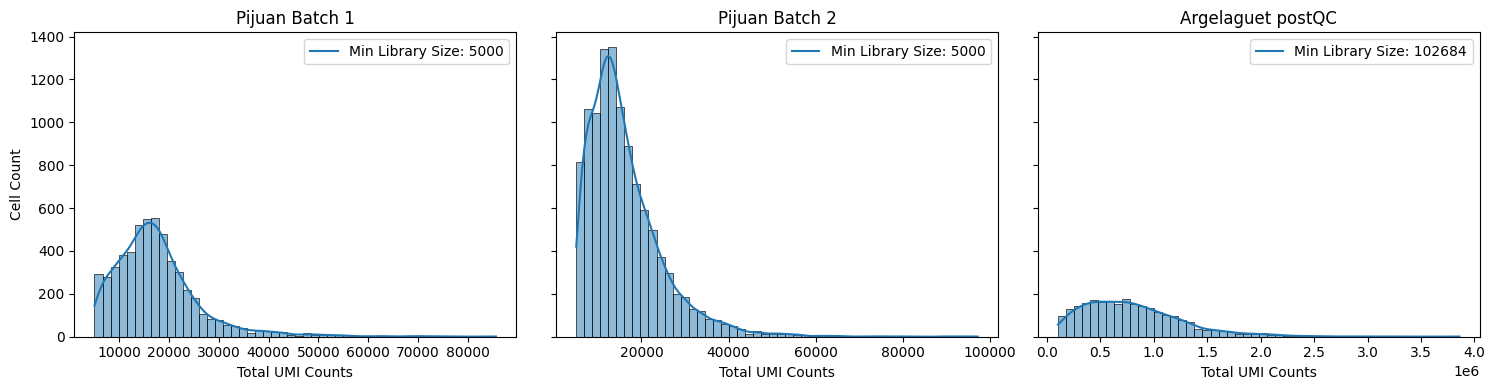

In [7]:
# Set up the figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

min_lib_1 = pb_batch1.obs["total_counts"].min()
min_lib_2 = pb_batch1.obs["total_counts"].min()
min_lib_3 = arg.obs["total_counts"].min()
min_lib_4 = arg_pass_rnaQC.obs["total_counts"].min()


# Plot for Dataset 1
sns.histplot(pb_batch1.obs["total_counts"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Pijuan Batch 1")
axes[0].set_xlabel("Total UMI Counts")
axes[0].set_ylabel("Cell Count")
axes[0].legend([f"Min Library Size: {min_lib_1:.0f}"], loc="upper right", frameon=True)


# Plot for Dataset 2
sns.histplot(pb_batch2.obs["total_counts"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Pijuan Batch 2")
axes[1].set_xlabel("Total UMI Counts")
axes[1].legend([f"Min Library Size: {min_lib_2:.0f}"], loc="upper right", frameon=True)

# Plot for Dataset 3
sns.histplot(arg_pass_rnaQC.obs["total_counts"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Argelaguet postQC")
axes[2].set_xlabel("Total UMI Counts")
axes[2].legend([f"Min Library Size: {min_lib_4:.0f}"], loc="upper right", frameon=True)


# Adjust layout
plt.tight_layout()
plt.show()

Inference:
*   Pijuan Datasets: The coverage threshold is 5000. Cells with total UMI count across all genes >5000 are retained.
* Argelaguet post QC: The coverage threshold is 100,. Cells with total UMI count across all genes >100,000 are retained.

These findings are consistent with the information supplied in the respective papers.


## 2.2: Visualise - Gene Expression per cell

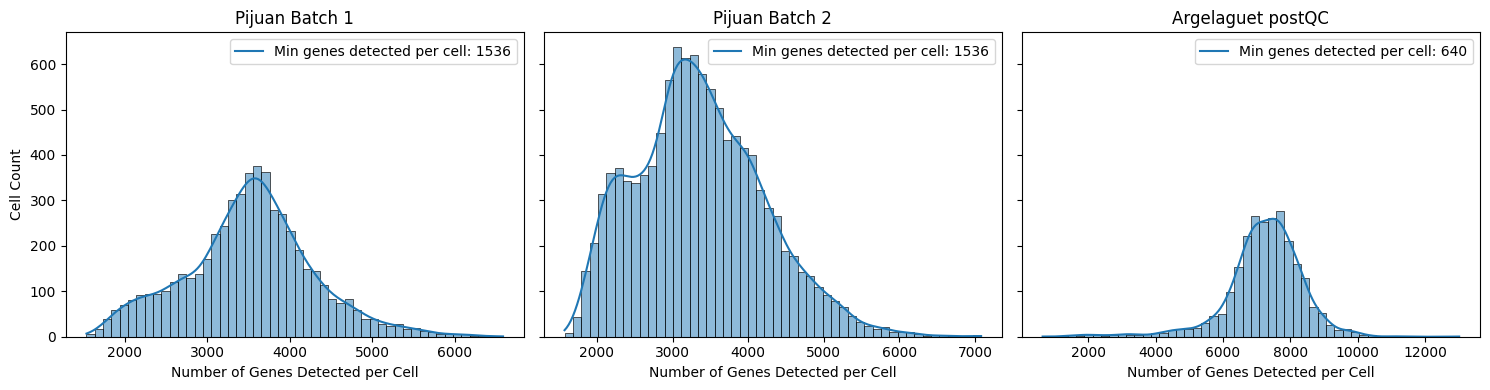

In [8]:
# Set up the figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

min_lib_1 = pb_batch1.obs["n_genes_by_counts"].min()
min_lib_2 = pb_batch1.obs["n_genes_by_counts"].min()
min_lib_3 = arg_pass_rnaQC.obs["n_genes_by_counts"].min()


# Plot for Dataset 1
sns.histplot(pb_batch1.obs["n_genes_by_counts"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Pijuan Batch 1")
axes[0].set_xlabel("Number of Genes Detected per Cell")
axes[0].set_ylabel("Cell Count")
axes[0].legend([f"Min genes detected per cell: {min_lib_1:.0f}"], loc="upper right", frameon=True)


# Plot for Dataset 2
sns.histplot(pb_batch2.obs["n_genes_by_counts"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Pijuan Batch 2")
axes[1].set_xlabel("Number of Genes Detected per Cell")
axes[1].legend([f"Min genes detected per cell: {min_lib_2:.0f}"], loc="upper right", frameon=True)


# Plot for Dataset 3
sns.histplot(arg_pass_rnaQC.obs["n_genes_by_counts"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Argelaguet postQC")
axes[2].set_xlabel("Number of Genes Detected per Cell")
axes[2].legend([f"Min genes detected per cell: {min_lib_3:.0f}"], loc="upper right", frameon=True)

# Adjust layout
plt.tight_layout()
plt.show()

Inference:
*   Pijuan Datasets: The Gene Expression threshold per cell is 1500. Cells where number of gene detected per cell is >1500 are retained.
* Argelaguet post QC: The Gene Expression threshold per cell is 500. Cells where number of gene detected per cell is >500 are retained.

These findings are consistent with the information supplied in the respective papers.


## 2.3: Visualise - Mitochondrial RNA in cells

The gene IDs in all three datasets are in Ensembl format. To be able to identify the mitochondrial content, a gene annotation file is needed to match the ENSEMBL ID to chromosome locations.

The gene annotation files used for reference here is the same as listed in the github code for Pijuan dataset(s)

In [72]:
#Get Ensembl Gene ID → Chromosome Mapping from BioMart
# server = Server(host="http://www.ensembl.org")
# mart = server['ENSEMBL_MART_ENSEMBL']
# dataset = mart['mmusculus_gene_ensembl']
# gene_map = dataset.query(
#     attributes=["ensembl_gene_id", "chromosome_name"]
#   )

# gene_map.head(5)

In [3]:
gene_map = pd.read_csv("/kaggle/input/rnaaseq/gene_map.csv")

In [74]:
gene_map

,Gene stable ID,Chromosome/scaffold name
0,ENSMUSG00000064336,MT
1,ENSMUSG00000064337,MT
2,ENSMUSG00000064338,MT
3,ENSMUSG00000064339,MT
4,ENSMUSG00000064340,MT
...,...,...
78293,ENSMUSG00000087203,2
78294,ENSMUSG00000085319,2
78295,ENSMUSG00000086652,2
78296,ENSMUSG00000092353,2


In [10]:
#Genes which have chromosome = MT have mitochondrial content
#Generating a list of such genes
mt_genes = gene_map[gene_map["Chromosome/scaffold name"] == "MT"]["Gene stable ID"].values

#Identify mitochondrial genes (MT chromosome) in each dataset
pb_batch1.var["mt_gene"] = pb_batch1.var_names.isin(mt_genes)
pb_batch2.var["mt_gene"] = pb_batch2.var_names.isin(mt_genes)
arg_pass_rnaQC.var["mt_gene"] = arg_pass_rnaQC.var_names.isin(mt_genes)

#Calculating mitochondrial content percentage for each dataset
pb_batch1.obs["mt_fraction_percent"] = (
    pb_batch1[:, pb_batch1.var["mt_gene"]].X.sum(axis=1) / pb_batch1.obs["total_counts"]
) * 100

pb_batch2.obs["mt_fraction_percent"] = (
    pb_batch2[:, pb_batch2.var["mt_gene"]].X.sum(axis=1) / pb_batch2.obs["total_counts"]
) * 100

arg_pass_rnaQC.obs["mt_fraction_percent"] = (
    arg_pass_rnaQC[:, arg_pass_rnaQC.var["mt_gene"]].X.sum(axis=1) / arg_pass_rnaQC.obs["total_counts"]
) * 100

In [11]:
sc.pp.calculate_qc_metrics(arg_pass_rnaQC,percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(pb_batch1,percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(pb_batch2,percent_top=None, log1p=False, inplace=True)


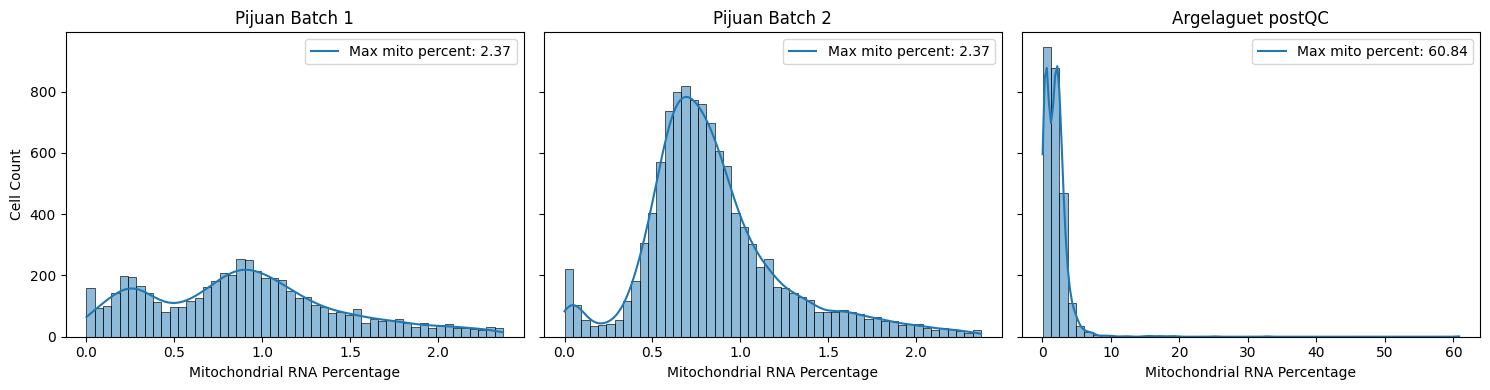

In [12]:
# Set up the figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

max_lib_1 = pb_batch1.obs["mt_fraction_percent"].max()
max_lib_2 = pb_batch1.obs["mt_fraction_percent"].max()
max_lib_3 = arg_pass_rnaQC.obs["mt_fraction_percent"].max()


# Plot for Dataset 1
sns.histplot(pb_batch1.obs["mt_fraction_percent"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Pijuan Batch 1")
axes[0].set_xlabel("Mitochondrial RNA Percentage")
axes[0].set_ylabel("Cell Count")
axes[0].legend([f"Max mito percent: {max_lib_1:.2f}"], loc="upper right", frameon=True)


# Plot for Dataset 2
sns.histplot(pb_batch2.obs["mt_fraction_percent"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Pijuan Batch 2")
axes[1].set_xlabel("Mitochondrial RNA Percentage")
axes[1].legend([f"Max mito percent: {max_lib_2:.2f}"], loc="upper right", frameon=True)


# Plot for Dataset 3
sns.histplot(arg_pass_rnaQC.obs["mt_fraction_percent"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Argelaguet postQC")
axes[2].set_xlabel("Mitochondrial RNA Percentage")
axes[2].legend([f"Max mito percent: {max_lib_3:.2f}"], loc="upper right", frameon=True)

# Adjust layout
plt.tight_layout()
plt.show()

Inference:
*   Pijuan datasets: The maximum mitochondrial content allowed per cell is 2.37%.
*   Argalaguet: The maximum mitochondrial content allowed per cell is 60.84%. Quality control for mitochondrial content has not been performed for this dataset.



## 2.4: Visualise - Top 50 Gene Expression

In [13]:
def calculate_top_50_genes(data):
  total_count = data.X.sum(axis=1)#total UMI count for each cell

  top_50_counts = np.zeros(data.n_obs)  # Placeholder for top 50 gene sums

  for cell_idx in range(data.n_obs):
    cell_expr = data.X[cell_idx, :]  # Extract expression for this cell

    # Convert sparse matrix to dense if necessary
    if scipy.sparse.issparse(cell_expr):
        cell_expr = cell_expr.toarray().flatten()
    else:
        cell_expr = cell_expr.flatten()

    top_50_counts[cell_idx] = np.sort(cell_expr)[-50:].sum()  # Sum of top 50 genes

  percentage_contribution = (top_50_counts / total_count) * 100  # Convert to percentage

  return percentage_contribution


In [14]:
pb_batch1.obs["top_50_gene_pct"] = calculate_top_50_genes(pb_batch1)
pb_batch2.obs["top_50_gene_pct"] = calculate_top_50_genes(pb_batch2)
arg_pass_rnaQC.obs["top_50_gene_pct"] = calculate_top_50_genes(arg_pass_rnaQC)

In [15]:
sc.pp.calculate_qc_metrics(arg_pass_rnaQC,percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(pb_batch1,percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(pb_batch2,percent_top=None, log1p=False, inplace=True)

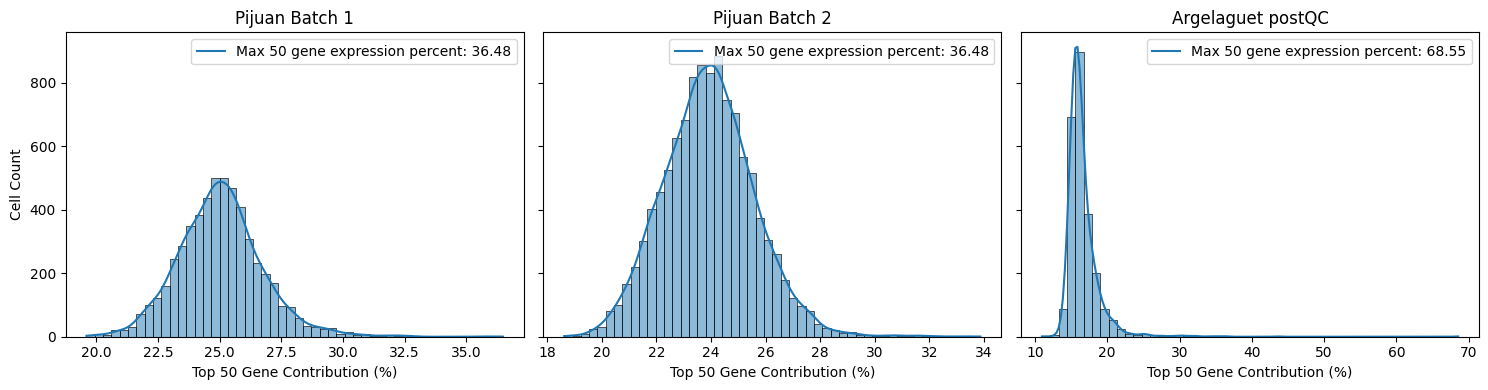

In [16]:
# Set up the figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

max_lib_1 = pb_batch1.obs["top_50_gene_pct"].max()
max_lib_2 = pb_batch1.obs["top_50_gene_pct"].max()
max_lib_3 = arg_pass_rnaQC.obs["top_50_gene_pct"].max()


# Plot for Dataset 1
sns.histplot(pb_batch1.obs["top_50_gene_pct"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Pijuan Batch 1")
axes[0].set_xlabel("Top 50 Gene Contribution (%)")
axes[0].set_ylabel("Cell Count")
axes[0].legend([f"Max 50 gene expression percent: {max_lib_1:.2f}"], loc="upper right", frameon=True)


# Plot for Dataset 2
sns.histplot(pb_batch2.obs["top_50_gene_pct"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Pijuan Batch 2")
axes[1].set_xlabel("Top 50 Gene Contribution (%)")
axes[1].legend([f"Max 50 gene expression percent: {max_lib_2:.2f}"], loc="upper right", frameon=True)


# Plot for Dataset 3
sns.histplot(arg_pass_rnaQC.obs["top_50_gene_pct"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Argelaguet postQC")
axes[2].set_xlabel("Top 50 Gene Contribution (%)")
axes[2].legend([f"Max 50 gene expression percent: {max_lib_3:.2f}"], loc="upper right", frameon=True)

# Adjust layout
plt.tight_layout()
plt.show()

### Visualising Gene vs UMI Count

/tmp/ipykernel_31/1525224122.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_31/1525224122.py:22: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_31/1525224122.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_31/1525224122.py:22: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(
/tmp/ipykernel_31/1525224122.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Ass

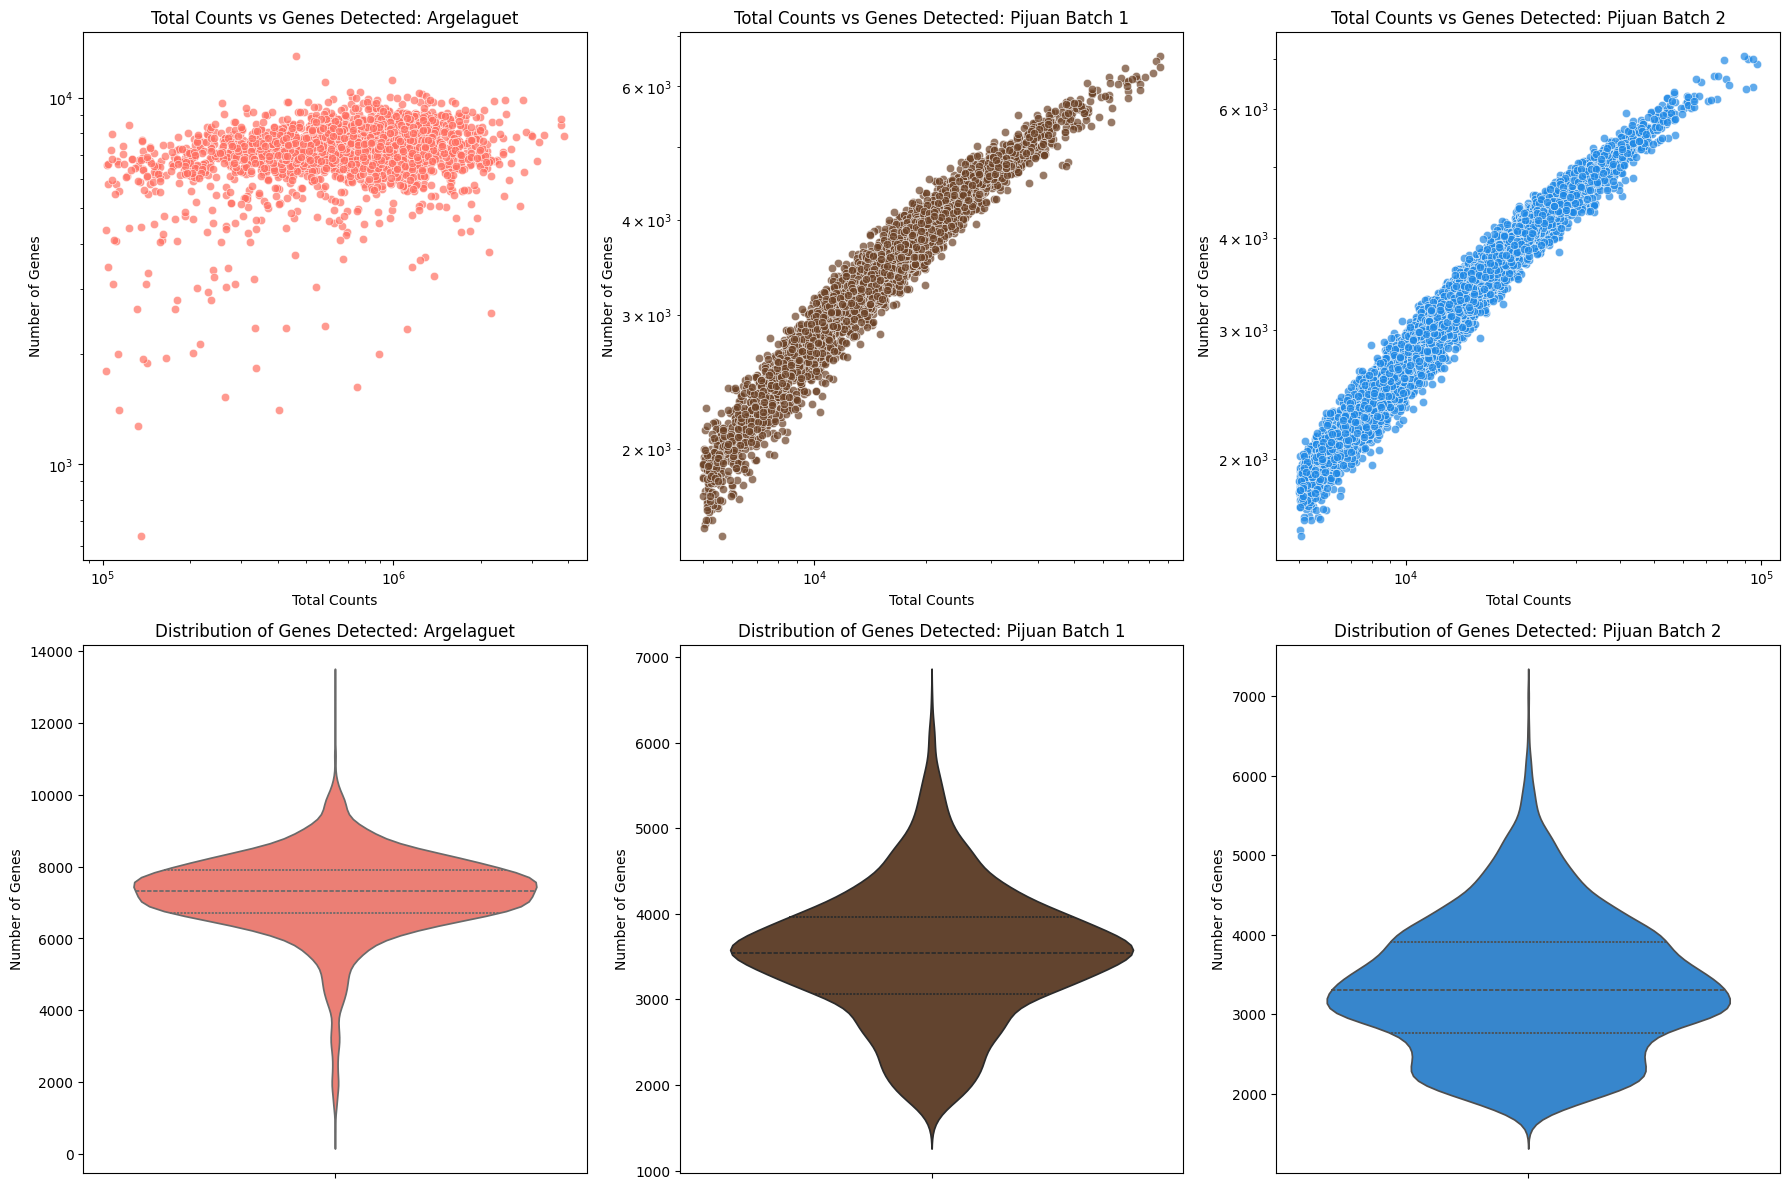

In [17]:
def plot_counts_vs_genes_comparison(adata_list,names):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    colors = ['#FF6F61', '#6B4226', '#1E88E5']
    
    for i, (adata, name) in enumerate(zip(adata_list, names)):
        sns.scatterplot(
            x='total_counts',
            y='n_genes_by_counts',
            data=adata.obs,
            ax=axes[0, i],
            alpha=0.7,
            color=colors[i % len(colors)],
           
        )
        axes[0, i].set_title(f'Total Counts vs Genes Detected: {name}')
        axes[0, i].set_xscale('log')
        axes[0, i].set_yscale('log')
        axes[0, i].set_xlabel('Total Counts')
        axes[0, i].set_ylabel('Number of Genes')
    
    for i, (adata, name) in enumerate(zip(adata_list, names)):
        sns.violinplot(
            y='n_genes_by_counts',
            data=adata.obs,
            ax=axes[1, i],
            inner='quartile',
            scale='width',
            palette=[colors[i % len(colors)]]
        )
        axes[1, i].set_title(f'Distribution of Genes Detected: {name}')
        axes[1, i].set_ylabel('Number of Genes')
    
    plt.tight_layout()
    plt.show()


# Call the function with your datasets
plot_counts_vs_genes_comparison([arg_pass_rnaQC, pb_batch1, pb_batch2], 
                       ['Argelaguet', 'Pijuan Batch 1', 'Pijuan Batch 2'])




## 2.5: Adjusting Quality Control (QC) Thresholds to the Stricter Standard

When working with multiple scRNA-seq datasets, differences in quality control (QC) thresholds can introduce biases, making comparisons inconsistent. To ensure harmonization, we apply the stricter QC threshold across all the datasets.

This ensures:
* Uniform filtering criteria - Avoids discrepancies due to different preprocessing pipelines.
* Better comparability - Ensures that differences in downstream analyses arise from biological variation, not preprocessing differences.
* Consistent cell retention - Prevents artificially inflating cell counts in one dataset while keeping only high-quality cells in another.


In [83]:
# Defining the QC table
qc_table = pd.DataFrame({
    "QC Methods": [
        "Coverage Threshold",
        "Gene Expression",
        "Mitochondrial Gene Expression"
    ],
    "Pijuan (Cell Retention Threshold)": [">5000", ">1000", "<2.37% (calculated using MAD)"],
    "Argelaguet (Cell Retention Threshold)": [">100,000", ">500", "Not performed"]
})


from IPython.display import display
display(qc_table)

,QC Methods,Pijuan (Cell Retention Threshold),Argelaguet (Cell Retention Threshold)
0,Coverage Threshold,>5000,">100,000"
1,Gene Expression,>1000,>500
2,Mitochondrial Gene Expression,<2.37% (calculated using MAD),Not performed


The coverage threshold for Pijuan cannot be changed to >100,000 since the sequencing depth for Pijuan is considerably low as seen while inspecting the coverage threshold. The maximum library size for Pijuan datasets are less than 95,000. This might be attributed to the sequencing method used for both the datasets.

Therefore the only changes being made, are to the Argelaguet dataset:


*   Gene Expression threshold changed from >500 to >1000
*   Mitochodrial Gene Expression threshold will be calculated using MAD (same as the method used in Pijuan dataset) and consequently filtered based on the calculate threshold



### 2.5.1: Resetting Argelaguet Gene Expression threshold (>1000)

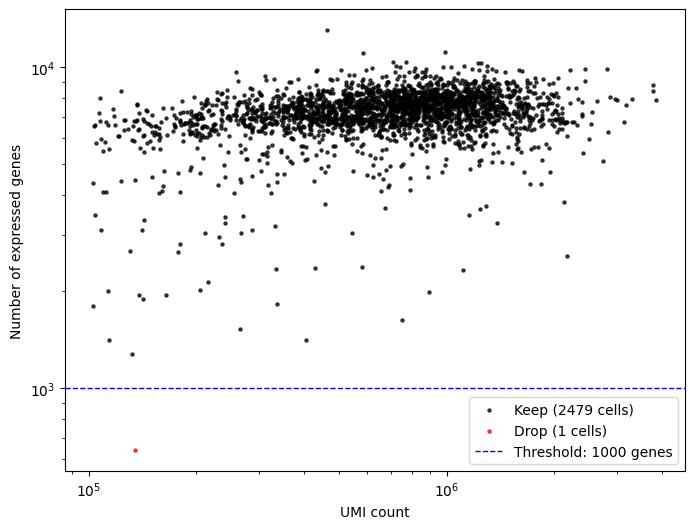

In [18]:
# Re-calculate QC metrics
sc.pp.calculate_qc_metrics(arg_pass_rnaQC, percent_top=None, log1p=False, inplace=True)

def visualization_gene_expression(data, gene_threshold):
    # Extract necessary values
    umi_counts = data.obs["total_counts"]
    num_expressed_genes = data.obs["n_genes_by_counts"]

    # Identify keep/drop cells
    keep_mask = num_expressed_genes > gene_threshold
    drop_mask = ~keep_mask  # Opposite of keep_mask

    # Count cells in each category
    keep_count = keep_mask.sum()
    drop_count = drop_mask.sum()

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(umi_counts[keep_mask], num_expressed_genes[keep_mask],
                label=f"Keep ({keep_count} cells)", color="black", alpha=0.7, s=5)
    plt.scatter(umi_counts[drop_mask], num_expressed_genes[drop_mask],
                label=f"Drop ({drop_count} cells)", color="red", alpha=0.7, s=5)

    # Add horizontal threshold line
    plt.axhline(y=gene_threshold, color="blue", linestyle="--", linewidth=1,
                label=f"Threshold: {gene_threshold} genes")

    # Log scale for better visualization
    plt.xscale("log")
    plt.yscale("log")

    # Labels & Legend
    plt.xlabel("UMI count")
    plt.ylabel("Number of expressed genes")
    plt.legend()
    plt.show()

visualization_gene_expression(arg_pass_rnaQC,1000)

In [19]:
#Function to filter based on gene expression threshold
def filter_gene_expression(data,UMI_threshold):
  min_genes = UMI_threshold  # Minimum genes per cell

  # Apply filtering
  data = data[data.obs["n_genes_by_counts"] > min_genes, :]

  return data

arg_pass_rnaQC = filter_gene_expression(arg_pass_rnaQC,1000)

### 2.5.2: Setting Argelaguet Mitochondrial Gene Expression threshold (Using MAD)

In [20]:
# Re-calculate QC metrics
sc.pp.calculate_qc_metrics(arg_pass_rnaQC, percent_top=None, log1p=False, inplace=True)
arg_pass_rnaQC.var["mt_gene"] = arg_pass_rnaQC.var_names.isin(mt_genes)
arg_pass_rnaQC.obs["mt_fraction"] = (
    arg_pass_rnaQC[:, arg_pass_rnaQC.var["mt_gene"]].X.sum(axis=1) / arg_pass_rnaQC.obs["total_counts"]
  )

def calculate_mito_threshold(data,gene_map):

  mt_fraction = np.array(data.obs["mt_fraction"])
  # Calculate p-values
  median_mt_fraction = np.median(mt_fraction)
  mad_mt_fraction = np.median(np.abs(mt_fraction - median_mt_fraction))  # Median Absolute Deviation
  mt_p = norm.sf(mt_fraction, loc=median_mt_fraction, scale=mad_mt_fraction)  # Use survival function for upper tail

  # Adjust p-values using FDR method
  _, p_adjusted, _, _ = multipletests(mt_p, method='fdr_bh')

  # Calculate the minimum fraction where the adjusted p-value is less than 0.05
  mt_lim = np.min(mt_fraction[p_adjusted < 0.05])

  return mt_lim

mt_lim = calculate_mito_threshold(arg_pass_rnaQC,gene_map)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_qc.py:144: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


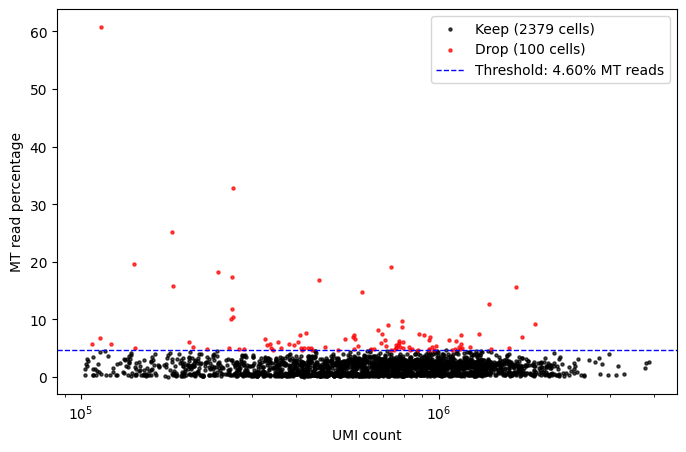

In [21]:
def plot_mt_read_percentage(data, mt_lim):

    # Extract values and convert fraction to percentage
    umi_counts = data.obs["total_counts"]
    mt_read_percentage = data.obs["mt_fraction"] * 100  # Convert to percentage
    mt_lim_percentage = mt_lim * 100  # Convert threshold to percentage

    # Identify keep/drop cells
    keep_mask = mt_read_percentage <= mt_lim_percentage
    drop_mask = ~keep_mask  # Opposite of keep_mask

    # Count cells in each category
    keep_count = keep_mask.sum()
    drop_count = drop_mask.sum()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(umi_counts[keep_mask], mt_read_percentage[keep_mask],
                label=f"Keep ({keep_count} cells)", color="black", alpha=0.7, s=5)
    plt.scatter(umi_counts[drop_mask], mt_read_percentage[drop_mask],
                label=f"Drop ({drop_count} cells)", color="red", alpha=0.7, s=5)

    # Add horizontal threshold line
    plt.axhline(y=mt_lim_percentage, color="blue", linestyle="--", linewidth=1,
                label=f"Threshold: {mt_lim_percentage:.2f}% MT reads")

    # Log scale for better visualization
    plt.xscale("log")

    # Labels & Legend
    plt.xlabel("UMI count")
    plt.ylabel("MT read percentage")
    plt.legend()
    plt.show()

plot_mt_read_percentage(arg_pass_rnaQC,mt_lim)

In [22]:
def filter_mitochodrial_gene_expression(data,mt_lim):
  max_mito_percent = mt_lim*100  # Remove cells with >max_mito_percent% mitochondrial RNA

  # Apply filtering
  data = data[data.obs["mt_fraction_percent"] < max_mito_percent, :]

  return data

arg_pass_rnaQC = filter_mitochodrial_gene_expression(arg_pass_rnaQC,mt_lim)

In [23]:
Argelaguet_undefined_celltypes = arg_pass_rnaQC.obs["celltype"].isna().sum()
PijuanBatch1_undefined_celltypes = pb_batch1.obs["celltype"].isna().sum()
PijuanBatch2_undefined_celltypes = pb_batch2.obs["celltype"].isna().sum()

print(f"The number of undefined celltypes in Pijuan Batch 1 dataset are {PijuanBatch1_undefined_celltypes}.")
print(f"The number of undefined celltypes in Pijuan Batch 2 dataset are {PijuanBatch2_undefined_celltypes}.")
print(f"The number of undefined celltypes in Argelaguet dataset are {Argelaguet_undefined_celltypes}.")

The number of undefined celltypes in Pijuan Batch 1 dataset are 489.
The number of undefined celltypes in Pijuan Batch 2 dataset are 1606.
The number of undefined celltypes in Argelaguet dataset are 7.


In [24]:
sc.pp.calculate_qc_metrics(arg_pass_rnaQC, log1p=False, percent_top=False, inplace=True)
sc.pp.calculate_qc_metrics(pb_batch1, log1p=False, percent_top=False,inplace=True)
sc.pp.calculate_qc_metrics(pb_batch2, log1p=False, percent_top=False, inplace=True)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_qc.py:144: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


In [25]:
arg_pass_rnaQC

AnnData object with n_obs × n_vars = 2378 × 22084
    obs: 'pass_rnaQC', 'stage', 'celltype', 'n_genes_by_counts', 'total_counts', 'mt_fraction_percent', 'top_50_gene_pct', 'mt_fraction'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt_gene'

In [26]:
arg = arg_pass_rnaQC.copy()
pb1 = pb_batch1.copy()
pb2 = pb_batch2.copy()

### 2.5.3: Doublet Removal

In [8]:
!pip install scrublet scanpy statsmodels


In [9]:
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.2 MB/s eta 0:00:0000:010:01


In [ ]:
# 2. Doublet scoring
import scrublet


# Proceed with modified doublet detection
def doublet_removal(adata):
    # Add dummy 'sample' column to enable pipeline compatibility
    adata.obs['sample'] = "sample1"  # All cells assigned to one sample

    # 1. Doublet scoring with Scrublet
    scrub = scrublet.Scrublet(adata.X)
    adata.obs['doublet_score'], _ = scrub.scrub_doublets()

    # 2. Clustering (no per-sample loop needed)
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata, key_added='cluster')

    def mad_threshold_single(scores, clusters, fdr=0.1):
        cluster_stats = pd.DataFrame({
            'cluster': clusters,
            'score': scores
        }).groupby('cluster')['score'].median().reset_index()
        
        medians = cluster_stats['score']
        global_median = np.median(medians)
        upper_medians = medians[medians > global_median]
        mad = stats.median_abs_deviation(upper_medians - global_median, scale='normal') if len(upper_medians) > 0 else 0
        
        cluster_stats['p_value'] = stats.norm.sf((medians - global_median)/mad)
        
        # Fix: Correctly unpack 4 return values from multipletests
        reject, fdr_corrected, _, _ = multipletests(cluster_stats['p_value'], method='fdr_bh')
        
        return cluster_stats['cluster'][fdr_corrected < fdr].values

    doublet_clusters = mad_threshold_single(adata.obs['doublet_score'], adata.obs['cluster'])
    adata.obs['doublet'] = adata.obs['cluster'].isin(doublet_clusters)

    # 4. Reporting
    print(f"Cells removed: {adata.obs['doublet'].sum()}/{adata.n_obs}")
    
    return adata.copy(),adata[~adata.obs['doublet']].copy()



In [30]:
arg,arg_doublet = doublet_removal(arg)
pb1,pb1_doublet = doublet_removal(pb1)
pb2,pb2_doublet = doublet_removal(pb2)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 16.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.3%
Elapsed time: 4.3 seconds


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 22084 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
2025-04-23 13:28:23.404759: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745414903.601336      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745414903.658251      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_31/1522612171.py:16: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future default

Cells removed: 19/2378
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.45
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 50.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.9%
Elapsed time: 6.7 seconds


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 29452 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/tmp/ipykernel_31/1522612171.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('cluster')['score'].median().reset_index()


Cells removed: 593/5455
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 50.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.7%
Elapsed time: 16.7 seconds


/usr/local/lib/python3.11/dist-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 29452 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(
/tmp/ipykernel_31/1522612171.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('cluster')['score'].median().reset_index()


Cells removed: 523/11118


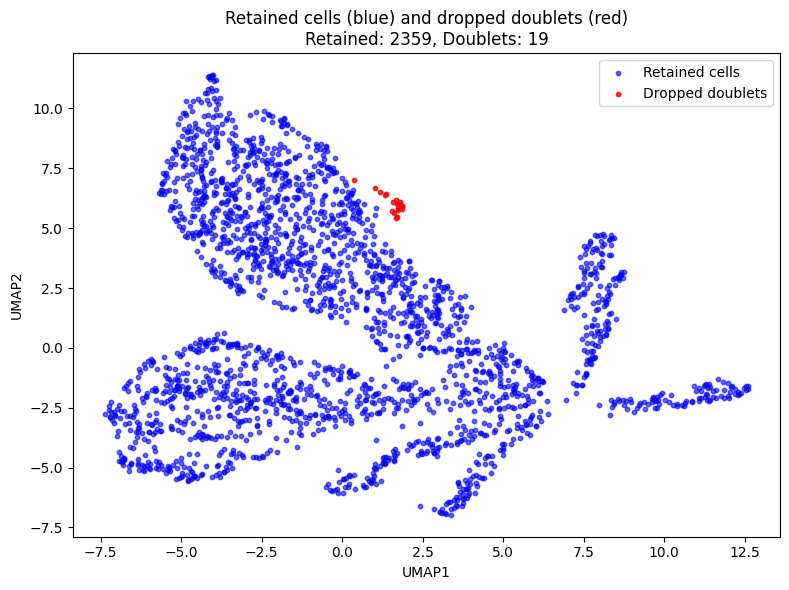

In [41]:
def plot_doublet(adata):
# Run UMAP if not already done
    if 'X_umap' not in adata.obsm:
     
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)
    
    # Create scatter plot: retained (blue), doublet (red)
    coords = adata.obsm['X_umap']
    is_doublet = adata.obs['doublet'].values
    
    plt.figure(figsize=(8, 6))
    plt.scatter(coords[~is_doublet, 0], coords[~is_doublet, 1], 
                c='blue', s=10, alpha=0.6, label='Retained cells')
    plt.scatter(coords[is_doublet, 0], coords[is_doublet, 1], 
                c='red', s=10, alpha=0.8, label='Dropped doublets')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend()
    plt.title(f'Retained cells (blue) and dropped doublets (red)\n'
              f'Retained: {np.sum(~is_doublet)}, Doublets: {np.sum(is_doublet)}')
    plt.tight_layout()
    plt.show()

plot_doublet(arg)

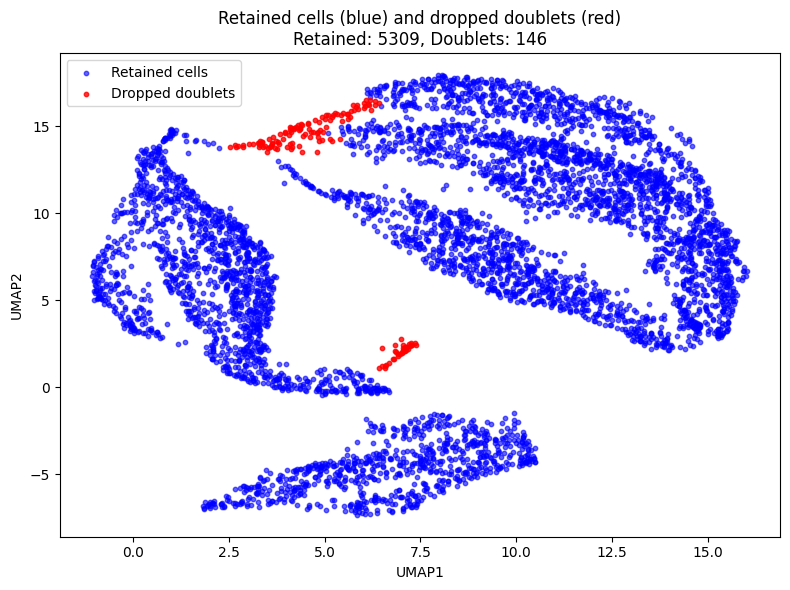

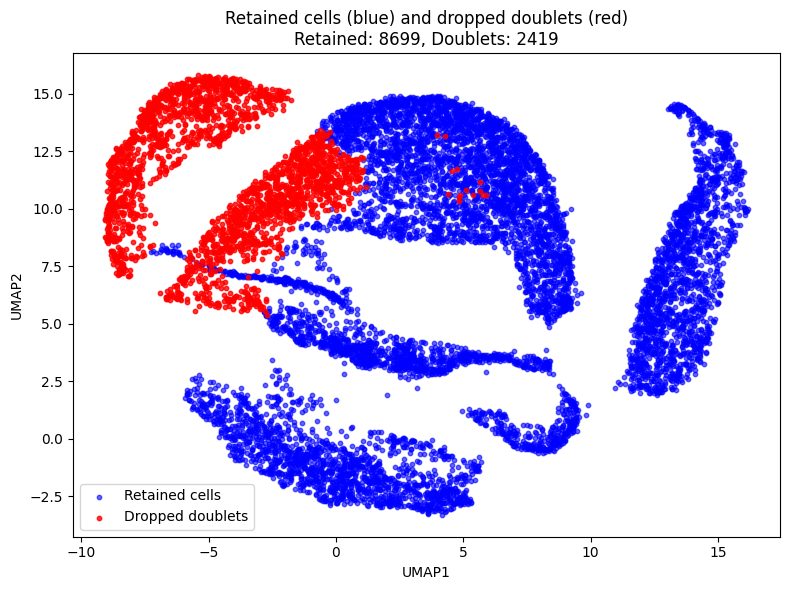

In [42]:
plot_doublet(pb1)
plot_doublet(pb2)



ModuleNotFoundError: No module named 'sknetwork'

In [31]:
sc.pp.calculate_qc_metrics(arg_doublet,log1p=False,percent_top=False,inplace=True)
sc.pp.calculate_qc_metrics(pb1_doublet,log1p=False,percent_top=False,inplace=True)
sc.pp.calculate_qc_metrics(pb2_doublet,log1p=False,percent_top=False,inplace=True)


In [32]:
arg_doublet.write("/kaggle/working/arg_qc.h5ad")
pb1_doublet.write("/kaggle/working/pb1_qc.h5ad")
pb2_doublet.write("/kaggle/working/pb2_qc.h5ad")


... storing 'stage' as categorical
... storing 'celltype' as categorical
... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'celltype' as categorical
... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'celltype' as categorical
... storing 'sample' as categorical
